In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import jax.numpy as jnp
import jax

In [2]:
x = np.linspace(0,2*np.pi,51)
y = np.linspace(0,5*np.pi,21)
dx = x[1]-x[0]
dy = y[1]-y[0]
print(dx,dy)
xgrid,ygrid = np.meshgrid(x,y)
print(xgrid.shape,ygrid.shape)
print(xgrid.size)

0.12566370614359174 0.7853981633974483
(21, 51) (21, 51)
1071


In [3]:
def fun(x,y):
    return np.sin(x) + np.sin(y+2*x)


dfdx_analytical = np.cos(xgrid)+ 2*np.cos(ygrid+2*xgrid)
dfdy_analytical = np.cos(ygrid+2*xgrid)

f = fun(xgrid,ygrid)
f.shape

(21, 51)

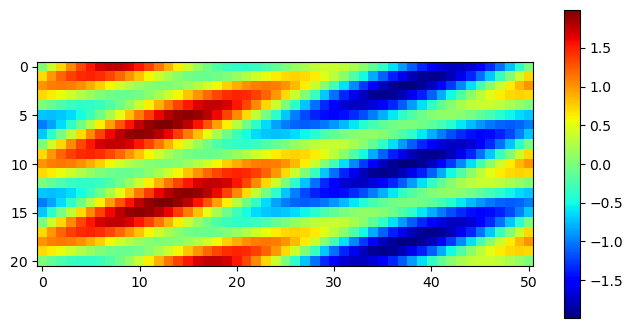

max f 1.9901414297427493, min f -1.9901414297427493, average f 0.8047088144797634, rms 0.9897292250233427


In [4]:
fig = plt.figure(figsize=(8,4))
im = plt.imshow(f,'jet')
plt.colorbar(im)
plt.show()
print(f"max f {np.max(f)}, min f {np.min(f)}, average f {np.mean(np.abs(f))}, rms {np.mean(f**2)}")

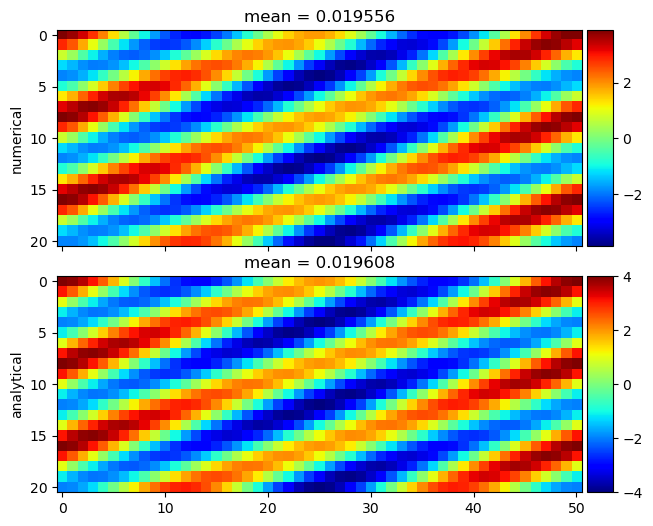

In [5]:
dfdx = np.gradient(f,dx,axis=1,edge_order=1)
dfdy = np.gradient(f,dy,axis=0,edge_order=1)

fig = plt.figure(figsize=(8,6))
grid = ImageGrid(fig,111,(2,1),cbar_mode='each',axes_pad=(0.05,0.3))
for ax, cax, data in zip(grid, grid.cbar_axes,[dfdx+dfdy, dfdx_analytical+dfdy_analytical]):
    im = ax.imshow(data,'jet')
    cax.colorbar(im)
    ax.set_title(f'mean = {np.mean(data):.6f}')
grid.axes_all[0].set_ylabel('numerical')
grid.axes_all[1].set_ylabel('analytical')
plt.show()

In [6]:
abs_e = np.mean((dfdx+dfdy) - (dfdx_analytical+dfdy_analytical))
square_e = np.mean(((dfdx+dfdy) - (dfdx_analytical+dfdy_analytical))**2)
# square_e = np.mean(((dfdx) - (dfdx_analytical))**2)
print(f'mean absolute error {abs_e}, mean squared error {square_e}')

mean absolute error -5.1565043676541494e-05, mean squared error 0.014951055757695774


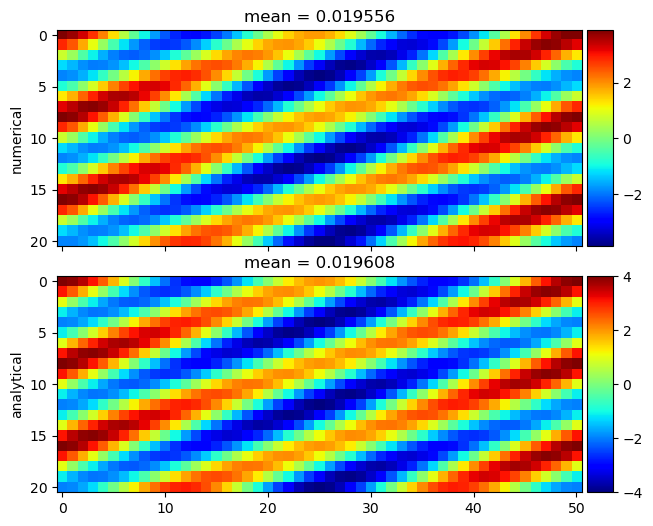

In [7]:
r = dfdx + dfdy
r_analytical = dfdx_analytical + dfdy_analytical

fig = plt.figure(figsize=(8,6))
grid = ImageGrid(fig,111,(2,1),cbar_mode='each',axes_pad=(0.05,0.3))
for ax, cax, data in zip(grid, grid.cbar_axes,[r,r_analytical]):
    im = ax.imshow(data,'jet')
    cax.colorbar(im)
    ax.set_title(f'mean = {np.mean(data):.6f}')
grid.axes_all[0].set_ylabel('numerical')
grid.axes_all[1].set_ylabel('analytical')
plt.show()

In [8]:
abs_e = np.mean(np.abs(r - r_analytical))
square_e = np.mean((r - r_analytical)**2)
# square_e = np.mean(((dfdx) - (dfdx_analytical))**2)
print(f'mean absolute error {abs_e}, mean squared error {square_e}')

mean absolute error 0.0969762224420933, mean squared error 0.014951055757695774


In [9]:
f.shape

(21, 51)

In [ ]:
def derivative2(f,dt):
    